In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
from gensim import corpora, models
from gensim.models import word2vec
import xgboost as xgb 
%matplotlib inline

/home/digitman/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/digitman/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD

Using Theano backend.


In [3]:
data1 = pd.read_csv('data/comments_vrn.csv.gz')
data2 = pd.read_csv('data/comments_ekb.csv.gz')
data = pd.concat((data1, data2))

In [4]:
data.shape

(284464, 6)

In [5]:
data.is_gum.value_counts()

1.0    151625
0.0    132839
Name: is_gum, dtype: int64

In [6]:
data.sex = data.sex == 2
data.sex = data.sex.apply(int)

In [7]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,9048238,Вжух даже здесь,0.0,20,1,1
1,9048238,И пишите аккуратнее 😞,0.0,12,3,1
2,9048238,Это #имбрина 😏,0.0,21,0,1


In [8]:
text = ''
for t in data.text.values:
    text += '\n' + t

In [9]:
uniq_text = set(text)

In [10]:
'd' in uniq_text

True

### Length of comments (symbols)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284464 entries, 0 to 98851
Data columns (total 6 columns):
from_id    284464 non-null int64
text       284464 non-null object
is_gum     284464 non-null float64
hour       284464 non-null int64
likes      284464 non-null int64
sex        284464 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 15.2+ MB


In [12]:
lenghts_symb = np.array([len(m) for m in data.text.values])

In [13]:
lenghts_symb.mean(), np.median(lenghts_symb)

(77.168362253220096, 47.0)

In [14]:
min(lenghts_symb), max(lenghts_symb)

(1, 9947)

In [15]:
sum(lenghts_symb)

21951621

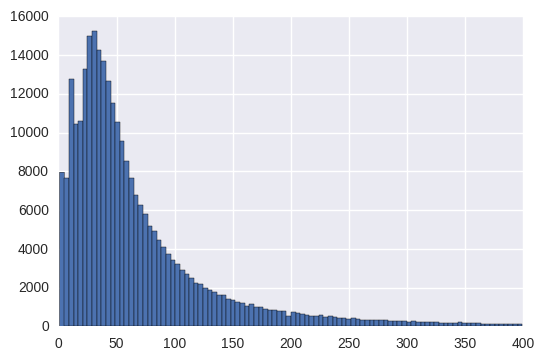

In [16]:
plt.hist(lenghts_symb[lenghts_symb < 400], bins=100);

In [17]:
print('{:.2f}% of comments are shorter than {} symbols'
      .format(lenghts_symb[lenghts_symb < 400].shape[0] / lenghts_symb.shape[0] * 100, 500))

98.36% of comments are shorter than 500 symbols


In [18]:
print('{:.2f}% of comments are longer than {} symbols'
      .format(lenghts_symb[lenghts_symb > 15].shape[0] / lenghts_symb.shape[0] * 100, 15))

87.24% of comments are longer than 15 symbols


### Length of comments (words)

In [19]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [20]:
lenghts_word.mean(), np.median(lenghts_word)

(11.478580769447101, 7.0)

In [21]:
min(lenghts_word), max(lenghts_word)

(0, 1612)

In [22]:
sum(lenghts_word) # total words

3265243

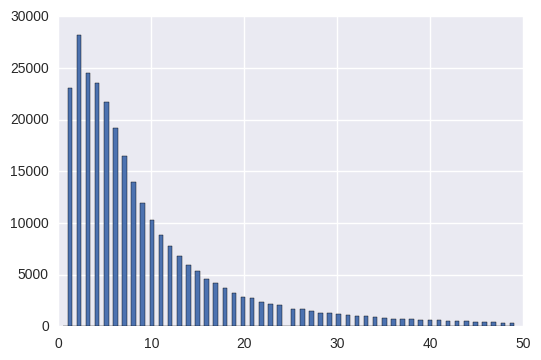

In [23]:
plt.hist(lenghts_word[lenghts_word < 50], bins=100);

In [24]:
print('{:.2f}% of comments are shorter than {} words'
      .format(lenghts_word[lenghts_word < 50].shape[0] / lenghts_word.shape[0] * 100, 50))

97.19% of comments are shorter than 50 words


In [25]:
print('{:.2f}% of comments are longer than {} words'
      .format(lenghts_word[lenghts_word > 4].shape[0] / lenghts_word.shape[0] * 100, 4))

65.08% of comments are longer than 4 words


### Count of unique (words)

In [26]:
words_ = np.array([m.split() for m in data.text.values])

In [27]:
words = []
for w in words_:
    words.extend(w)

In [28]:
len(words)

3265243

In [29]:
len(set(words))

500745

### Links

In [30]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 

In [31]:
links[:5]

['[id8407059|Евгений], во-первых, по цены. http://market.yandex.ru/search.xml?hid=91709&text=%D1%81%D1%87%D0%B5%D1%82%D1%87%D0%B8%D0%BA%20%D0%B3%D0%B0%D0%B7%D0%B0&srnum=117&ortext=%D1%81%D1%87%D0%B5%D1%82%D1%87%D0%B8%D0%BA%20%D0%B3%D0%B0%D0%B7%D0%B0 во-вторых, даже при отсутствии газонагревательных приборов разница расхода может составлять разы. Моя мать, например, любит газовой плитой кухню отапливать. В-третьих, тебя не смущает то, что электросчетчики ставили и ставят на любых потребителей, будь там хоть сортир с лампочкой? Ты просто не привык к этому, посему - возражаешь. А наличие прибора учета - это правильно. И ставят его, кстати, далеко не на один год. У нас уже лет 10 стоит.',
 '[id212860568|Дмитрий], ну измерь сам. Будешь удивлен http://maps.yandex.ru/?ll=39.211973%2C51.573975&spn=0.184536%2C0.086108&z=13&l=sat%2Cskl',
 '[id10072765|Александр], ты еще дрессировщика дрожжевых бактерий Жданова вспомни. Тоже "авторитет". с тем же успехом я тебе могу ответить этим: http://zenslim.

In [32]:
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.50% of comments contain links


## Preprocessing

### Dropping short and long

In [33]:
comments = data[(lenghts_word < 50) & (lenghts_word > 4)]

In [34]:
comments.shape

(177132, 6)

### Dropping with spam

In [35]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True for c in comments.text.values] 

In [36]:
comments = comments[without_link]

In [37]:
comments.shape

(176335, 6)

In [38]:
comments_lenghts = np.array([len(m) for m in comments.text.values])

In [39]:
comments_lenghts.argsort()[:10]

array([ 31876,  31809,  31729, 134619,  12582,  63201, 146522, 170450,
        51659,  31418])

In [40]:
comments.text.values[21846]

'[id16867860|Дмитрий], басс должен давить душу 😃'

### Make class balanced

In [41]:
comments_ = comments.copy()

In [55]:
comments_vc = comments_.is_gum.value_counts()
comments_vc

1.0    92485
0.0    83850
Name: is_gum, dtype: int64

In [56]:
delta = comments_vc[1] - comments_vc[0]
delta

8635

In [57]:
index_to_del = np.random.choice(comments_[comments_.is_gum == 1].index, delta, replace=False)
comments_.drop(index_to_del, inplace=True)

In [58]:
comments_.is_gum.value_counts()

1.0    82097
0.0    82051
Name: is_gum, dtype: int64

## Baseline

In [49]:
vectorizer = CountVectorizer(max_features=3000, ngram_range=(1, 3), analyzer='word', min_df=50)
X = vectorizer.fit_transform(comments.text.values)
y = comments.is_gum.values
# y = comments.sex.values

In [50]:
X.shape

(164163, 3000)

In [51]:
lr = lm.LogisticRegression()

In [52]:
np.random.seed(0)

In [53]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.52251746616565398, 0.0097133997712392367)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, comments.is_gum, test_size=0.2, random_state=0)

In [220]:
# X_train, X_test, y_train, y_test = train_test_split(word_features.toarray(), comments.is_gum, test_size=0.2, random_state=0)

In [55]:
X_train.shape, y_train.shape

((131330, 3000), (131330,))

In [56]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.56696007066061582

In [57]:
vectorizer.get_feature_names()[1565]

'не курсе'

In [68]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 2000, 50)]

array(['кому не', 'апреля', 'мне вот', 'они там', 'жизни', 'памятник',
       'говорят что', 'новый год', 'ним', 'каждом', 'за то что', 'ныть',
       'интересно', 'го', 'выйти', 'парни', 'она не', 'обычный',
       'он просто', 'лучше бы', 'нас', 'всего лишь', 'находится', 'полный',
       'не слышал', 'воды', 'какой нибудь', 'живешь', 'одни', 'делали',
       'была', 'история', 'давно не', 'им не', 'вася', 'взял', 'не люблю',
       'не понятно', 'xd', 'осень', 'москвы', 'видно', 'для того',
       'возрасте', 'на что', 'как минимум', 'зачем', 'мусор', 'оттуда',
       'данной'], 
      dtype='<U21')

### NN

In [69]:
model = Sequential()
model.add(Dense(3000, input_shape=(3000,)))
model.add(Activation(PReLU()))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
%%time
history = model.fit(X_train.toarray(), y_train,
                    nb_epoch=10, batch_size=1024,
                    verbose=1, validation_split=0.1)

Train on 75691 samples, validate on 8411 samples
Epoch 1/10
75691/75691 [==============================] - 191s - loss: 0.6784 - acc: 0.5569 - val_loss: 0.6698 - val_acc: 0.5706
Epoch 2/10
75691/75691 [==============================] - 189s - loss: 0.6332 - acc: 0.6315 - val_loss: 0.6774 - val_acc: 0.5693
Epoch 3/10
75691/75691 [==============================] - 187s - loss: 0.5874 - acc: 0.6802 - val_loss: 0.6905 - val_acc: 0.5662
Epoch 4/10
75691/75691 [==============================] - 193s - loss: 0.5066 - acc: 0.7561 - val_loss: 0.7157 - val_acc: 0.5638
Epoch 5/10
75691/75691 [==============================] - 183s - loss: 0.4028 - acc: 0.8364 - val_loss: 0.7490 - val_acc: 0.5710
Epoch 6/10
75691/75691 [==============================] - 181s - loss: 0.3049 - acc: 0.8963 - val_loss: 0.7803 - val_acc: 0.5707
Epoch 7/10
75691/75691 [==============================] - 181s - loss: 0.2307 - acc: 0.9300 - val_loss: 0.8260 - val_acc: 0.5675
Epoch 8/10
75691/75691 [========================

In [102]:
score = model.evaluate(X_test.toarray(), y_test,
                       batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

21026/21026 [==============================] - 18s    
Test score: 0.97831793148
Test accuracy: 0.556881955663


### XGB

In [75]:
params = {
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_matrics': 'error',
}

In [76]:
%%time
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

gbm = xgb.train(params, dtrain, 100, watchlist, verbose_eval=True, early_stopping_rounds=30)

[0]	train-error:0.407081	eval-error:0.432979
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 30 rounds.
[1]	train-error:0.404759	eval-error:0.434319
[2]	train-error:0.404394	eval-error:0.433923
[3]	train-error:0.403929	eval-error:0.433375
[4]	train-error:0.404104	eval-error:0.43371
[5]	train-error:0.404074	eval-error:0.433832
[6]	train-error:0.404066	eval-error:0.43374
[7]	train-error:0.40383	eval-error:0.43304
[8]	train-error:0.403853	eval-error:0.433162
[9]	train-error:0.403792	eval-error:0.432949
[10]	train-error:0.403891	eval-error:0.433314
[11]	train-error:0.403845	eval-error:0.433101
[12]	train-error:0.403921	eval-error:0.433162
[13]	train-error:0.403959	eval-error:0.43304
[14]	train-error:0.403921	eval-error:0.43304
[15]	train-error:0.403876	eval-error:0.43307
[16]	train-error:0.403914	eval-error:0.432949
[17]	train-error:0.403899	eval-error:0.43304
[18]	train-error:0.403998	eval-error:0.43304


In [72]:
sorted(gbm.get_fscore().items(), key=lambda x: -x[1])[:5]

[('f1522', 172), ('f2864', 94), ('f1403', 75), ('f2599', 60), ('f2945', 59)]

In [74]:
list(filter(lambda x: x[1] == 2864, vectorizer.vocabulary_.items()))

[('что', 2864)]

In [77]:
pred = gbm.predict(dvalid)

In [78]:
pred

array([ 0.29919821,  0.46582282,  0.58657163, ...,  0.73218793,
        0.57412434,  0.42641777], dtype=float32)

In [79]:
accuracy_score(y_test, pred > 0.5)

0.56708189930862241

## Testing meta features

In [38]:
is_man = np.reshape((comments.sex == 2).astype('int'), (-1, 1))

/home/digitman/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [39]:
is_with_like = np.reshape((comments.likes > 0).astype('int'), (-1, 1))

/home/digitman/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [40]:
X = pd.get_dummies(comments.hour, prefix='h').values
X = np.hstack((X, is_with_like, is_man))

In [41]:
def get_meta_features():
    features = pd.DataFrame()
    features['is_man'] = comments.sex == 2
    features['is_with_like'] = comments.likes > 0
    features = pd.concat((features, pd.get_dummies(comments.hour, prefix='h')), axis=1)
    return features

In [42]:
meta_features = get_meta_features()

In [43]:
meta_features.head()

,is_man,is_with_like,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
6,False,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,False,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [46]:
baseline_scores = cross_val_score(lr, meta_features, comments.is_gum, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.53262276325052182, 0.007688754442077058)

## Emoji

In [42]:
comments_list = comments.text.values

In [43]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [44]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [45]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [46]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

In [47]:
get_emoji(' 🔥 🔥 👏')

['👏', '🔥', '🔥']

In [48]:
get_emoji(' 🔥 🔥 👏', False)

['👏', '🔥']

#### If not done before

In [53]:
len(comments_list)

176335

In [54]:
%time emoji_from_comments_rep = list(map(get_emoji, comments_list))

CPU times: user 1h 19min 40s, sys: 520 ms, total: 1h 19min 41s
Wall time: 1h 19min 45s


In [55]:
with open('emoji_from_comments_rep_both.pkl', 'wb') as f:
    pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [49]:
with open('emoji_from_comments_rep_both.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)

In [50]:
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))

In [51]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [52]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'])

array([ 1.])

In [53]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'], repetition=False)

array([ 0.6])

In [54]:
len(comments_list), len(emoji_from_comments_rep)

(176335, 176335)

In [55]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)

In [56]:
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [57]:
(em_proportion_rep > 0.25).sum()

123

In [58]:
comments_list[em_proportion_rep > 0.25][:20]

array(['👍👍👍👍👍👍клааас❗❗❗❗ эта елка будееет самой красивой😂😂😂😂',
       'И здесь хорошо и там хорошо....👍👍👍👍👍👍👍👍👍',
       'Да что вы... Кому что нравится 😍😍😍😍👍👍👍👍👍👍👍👍',
       '😍😍😍😍😍😍и тишина и спокойствие 👍👍👍👍👍',
       'Кому как но Воронеж это воронеж любим и будем любить 😍😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '😂😂😂😂😂это еще что такое 😂😂😂😂😂👍👍👍',
       'Какая красота 👍👍👍👍👍👍👍с страшно аж 😂😂😂',
       '👍👍👍👍👍👍👍😍😍😍😍😍😍самый  лучший красивый город 😛😛😛',
       'Ух ты 😍😍😍😍👍👍👍ВВОРОНЕЖ САМЫЙ ЛУЧШИЙ ГОРОД НА ЗЕМЛЕ 👍👍👍👍👍👍👍👍👍💋💋💋💋💋',
       '😂😂😂😂😂👍👍👍👍👍вот те на царица прям', '😂😂😂😂😂👍👍👍👍а я так часто еду 😂😂😂',
       '😂😂😂😂а я ничего себе не скажу 👍👍👍',
       '😄😄😄😄главное чтоб я не проиграла😄😄😄😄',
       'С горем пополам... ❄  ❄  ❄  ❄  ❄  👍',
       '[id138651229|Никита], И прям перед НГ! 🎄 🎄 🍻 🍻 🍷 🍷 ❄ ❄ ❄ ❄ ❄ ❄',
       '😆 😆 😆 😆 😆 😆 😆 😆 😆 😆', '😂 😂 😂 😂 😂',
       'Кошмарный сон заниженных приор 😱 😱 😱 😱 😱 😱 😱 😱 😱 😱',
       'Сочное фото! 💫 🌟 ✨ 👍'], dtype=object

### Without repetition

In [59]:
(em_proportion_no_rep > 0.1).sum()

163

In [60]:
comments_list[em_proportion_rep > 0.1][:20]

array(['Это даже очень хорошоооо....👍👍👍👍👍ссвежооооо так давно не былооо👍👍👍😂😂😂',
       '👍👍👍👍👍👍клааас❗❗❗❗ эта елка будееет самой красивой😂😂😂😂',
       '[id262701277|Алексей], 😂😂😂😂😂👍👍👍👍только надо держаться от таких подальше....все мы хороши....',
       'А он ниче такой😂😂😂С ДНЕМ ВАРЕНЬЯ😍😍',
       '😍😂😂😂😂музыку надо слушать дома или в клубе...а в автобусе слушайте не довольных бабушек😂😂😂😂😂это интереснее',
       '[id134925409|Дарья], аааа это еще и он😂😂😂😂значит жена выгнала из дома😂😂😂😂😂😂',
       'Хата есть😂😂😂а где людей взять...?',
       'А мне нравится очень красивооо😍😍😍',
       '😂😂😂😂👍👍👍н ну это ж люди....\n😂😂😂блин а когда новый год???😂',
       'Чет я не врублюсь в чем смысл ??😂😂😂😂',
       '[id362041238|Алексей], 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂',
       '😂😂😂😂😂😂вот бы меня на купюру не плохооо было б😂😂😂',
       '[id68148212|Сергей], 😂😂😂😂я буду в самом сокууууууу😂😂😂😂😂',
       'Фигня полная как курили как ели как ездили так и будууут продолжать😂😂😂😂мы народ не

### Proportion of alphabetical symbols

In [61]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [62]:
abc_proportion = get_abc_proportion(comments_list)

In [63]:
abc_proportion[:10]

array([ 0.87179487,  0.81818182,  0.7398374 ,  0.88842975,  0.87711864,
        0.67213115,  0.93939394,  0.90909091,  0.79032258,  0.7721519 ])

In [64]:
sum(abc_proportion < 0.4)

345

In [65]:
comments_list[abc_proportion < 0.4][:20]

array(['+7 952 104 73 50', 'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '[id293964161|Вика], не на 20..на 16',
       '[id179033694|Анна], пободрей говоришь, ну лови\n ))))))))))))))))))))))))))))))))))',
       '[id32454177|Fancy], можно связаться..8 (800) 100-12-60 ))))',
       '[id16867860|Дмитрий], 19 мая, в 20:15',
       'Вариант на работе:\n\n4.0. Введение......................................................117',
       '[id213017431|Asmik], п. 4.1 п. 4.3 п.4.6 (!!!!)',
       'Радуйтесь :-D\n21.03 -1°..-3° Снег\n22.03 -6°..-8° Пер. облачность\n23.03 -8°..-10° Снег\n24.03 -6°..-8° Снег\n25.03 -5°..-7° Пер. облачность',
       '4я - 11% из них "+" 8% "-" 3%',
       '[id19704075|Мария], :-) ;-) :-D :-[ :-\\\nДостаточно?',
       '😆 😆 😆 😆 😆 😆 😆 😆 😆 😆', '😂 😂 😂 😂 😂', '8 950 762 98 65 Ждёмс)',
       '[id340505152|Оля], ну, 50 на 50', '[id7446980|Алёна], 😐 😕 😟 😟',
       'Катаюсь. 8960 119 91 54', '8, +7 (удивил, да? 😆)\n9601113330',
       '[id218830909|Анастасия], а 18 е

### Filling DataFrame

In [66]:
len(emoji_from_comments_no_rep)

176335

In [67]:
len(comments_list)

176335

In [68]:
comments.shape

(176335, 6)

In [69]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]

In [70]:
comments['em_proportion_rep'] = em_proportion_rep

In [71]:
comments['em_proportion_no_rep'] = em_proportion_no_rep

In [72]:
comments['abc_proportion'] = abc_proportion

In [73]:
comments.head(5)

,from_id,text,is_gum,hour,likes,sex,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion
6,9048238,"ну ппц, уже просто так телефон не зарядишь... 😆",0.0,22,4,1,😆,0.025641,0.025641,0.871795
7,10679122,"[id332962766|Игорь], они кагбэ намекают, что н...",0.0,20,0,1,,0.000000,0.000000,0.818182
8,10679122,"[id386347082|Jeg-Hater], просто вою! Бли-и-н.....",0.0,21,0,1,,0.000000,0.000000,0.739837
9,10679122,"[id332962766|Игорь], к восстановлению твоей ма...",0.0,21,1,1,,0.000000,0.000000,0.888430
12,10679122,"[id54238381|Андрей], ды конечно же, никто не р...",0.0,22,0,1,,0.000000,0.000000,0.877119


#### If message repeats more than one time - drop (spam)

In [74]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

395 different spam comments


In [75]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

1143 total count of spam comments


### Dropping outlier

In [76]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()

In [77]:
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [78]:
index_to_del = comments[(comments.em_proportion_rep > 0.2).values | (comments.abc_proportion < 0.5).values | 
                        (comments.text.value_counts() != 1).values].index

In [79]:
index_to_del.shape

(801,)

In [80]:
comments.drop(index_to_del, inplace=True)

In [81]:
comments.shape

(174000, 10)

In [82]:
comments_list = comments.text.values

### Replacing id

In [83]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'adddresssation'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('adddresssation')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [84]:
comments_list[:5]

array(['ну ппц, уже просто так телефон не зарядишь... 😆',
       'adddresssation они кагбэ намекают, что накручивают левых платежей не очень много. Суки они все.',
       'adddresssation просто вою! Бли-и-н... А знаешь, что такое буква "У" на некоторых автомобилях :)))) (сколько же дебилов на свете,а?)',
       'adddresssation к восстановлению твоей машины твой полис ОСАГО никакого отношения не имеет, он нужен только в том случае, когда _ты_ кого-то подобьешь. Тогда расходы несешь не ты (в каких-то пределах, разумеется), а страховщик. Это страховка ответственности, а не автомобиля.',
       'adddresssation ды конечно же, никто не рассчитывает. Зачем еще что-то рассчитывать, беря кредит?! И как ты там сказал? "Прости господи, Поло"? Да. Верх нищеты. Последняя черта перейдена :( Соотечественники пухнут с голоду, рецепты для похудания актуальны как никогда!'], 
      dtype='<U452')

In [85]:
comments_lenghts = np.array([len(m) for m in comments_list])

In [86]:
(comments_lenghts > 50).sum()

114440

In [87]:
len(comments_list)

174000

## Char-Rnn

### Preparing data

In [93]:
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

In [95]:
comments_for_char = []
for l, c in zip(comments_lenghts, comments_list):
    if l > 50:
        comments_for_char.append(c)

In [96]:
comments_for_char[:5]

['adddresssation они кагбэ намекают, что накручивают левых платежей не очень много. Суки они все.',
 'adddresssation просто вою! Бли-и-н... А знаешь, что такое буква "У" на некоторых автомобилях :)))) (сколько же дебилов на свете,а?)',
 'adddresssation к восстановлению твоей машины твой полис ОСАГО никакого отношения не имеет, он нужен только в том случае, когда _ты_ кого-то подобьешь. Тогда расходы несешь не ты (в каких-то пределах, разумеется), а страховщик. Это страховка ответственности, а не автомобиля.',
 'adddresssation ды конечно же, никто не рассчитывает. Зачем еще что-то рассчитывать, беря кредит?! И как ты там сказал? "Прости господи, Поло"? Да. Верх нищеты. Последняя черта перейдена :( Соотечественники пухнут с голоду, рецепты для похудания актуальны как никогда!',
 '(бегает по дому, орет) А-а-а!!!! Мне ездить на этом, на "п"? А-а-а-а!!!!']

In [97]:
joined_text = ''
for c in comments_for_char:
    joined_text += c.lower() + '\n'

In [98]:
joined_text[:100]

'adddresssation они кагбэ намекают, что накручивают левых платежей не очень много. суки они все.\naddd'

### Counting chars

In [99]:
counter = Counter(joined_text)

In [100]:
len(counter.values())

539

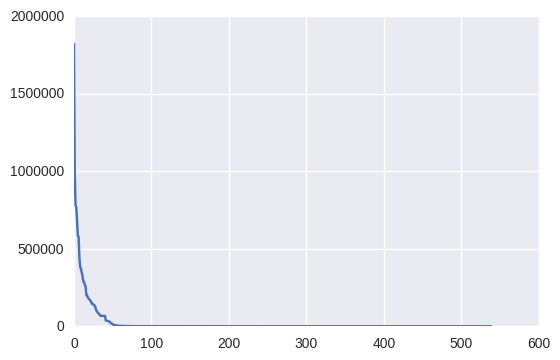

In [101]:
plt.plot(range(len(counter.values())), [x[1] for x in counter.most_common()]);

In [102]:
counter.most_common(10)

[(' ', 1822755),
 ('о', 992802),
 ('а', 779218),
 ('е', 768696),
 ('т', 671808),
 ('и', 584523),
 ('н', 576112),
 ('с', 439053),
 ('р', 384959),
 ('в', 370401)]

In [103]:
char_set = sorted([c[0] for c in counter.most_common(100)])

In [104]:
char_indices = dict((c, i) for i, c in enumerate(char_set))
indices_char = dict((c, i) for c, i in enumerate(char_set))

### Filling rare chars and to lower

In [105]:
'#' in char_set

False

In [106]:
comments_for_char_filled = []
for i, com in enumerate(comments_for_char):
    new_com = ''
    for ch in com.lower():
        if ch not in char_set:
            new_com += '#'
        else:
            new_com += ch
    comments_for_char_filled.append(new_com)

In [107]:
char_indices.update({'#': len(char_indices)})
indices_char.update({len(indices_char): '#'})

### Generating dataset

In [128]:
max_len = 40
step = 10
sentences = []
next_chars = []

In [129]:
for com in comments_for_char_filled:
    for i in range(0, len(com) - max_len, step):
        sentences.append(com[i: i + max_len])
        next_chars.append(com[i + max_len])

In [130]:
len(sentences)

835433

In [131]:
sentences[:5]

['adddresssation они кагбэ намекают, что н',
 'tion они кагбэ намекают, что накручивают',
 'агбэ намекают, что накручивают левых пла',
 'ают, что накручивают левых платежей не о',
 'акручивают левых платежей не очень много']

In [132]:
next_chars[:5]

['а', ' ', 'т', 'ч', '.']

### Vectorization

#### Mb sparse?

In [133]:
X = np.zeros((len(sentences), max_len, len(char_set) + 1), dtype=np.bool) # +1 because of filled rare chars with '#'
y = np.zeros((len(sentences), len(char_set) + 1), dtype=np.bool)
X.shape, y.shape

((835433, 40, 101), (835433, 101))

In [134]:
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

### Model LSTM

In [135]:
import sys

In [136]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, len(char_set) + 1)))
model.add(Dense(len(char_set) + 1))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.005)
model.compile(optimizer, 'categorical_crossentropy')

In [137]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 128)           117760      lstm_input_1[0][0]               
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 101)           13029       lstm_1[0][0]                     
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 101)           0           dense_1[0][0]                    
Total params: 130789
____________________________________________________________________________________________________


In [259]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [260]:
np.random.multinomial(1, [0.7, 0.2, 0.05, 0.01, 1], 10)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

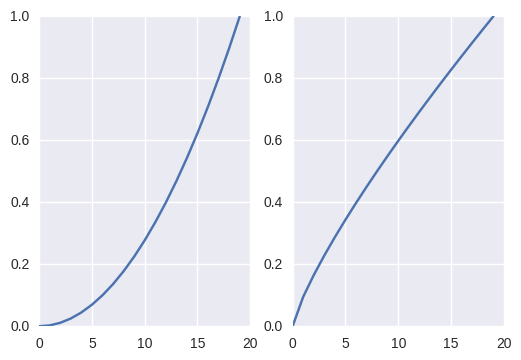

In [261]:
l = np.linspace(0, 1, 20)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.exp(np.log(l) / 0.5))
ax2.plot(np.exp(np.log(l) / 1.25))

In [ ]:
for iteration in range(1, 30):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = np.random.randint(0, len(comments_for_char_filled))

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = comments_for_char_filled[start_index]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(100):
            x = np.zeros((1, max_len, len(char_set) + 1))
            for t, char in enumerate(sentence[:40]):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
 23296/572200 [>.............................] - ETA: 2498s - loss: 2.9837

## Clearing comments

In [ ]:
from sklearn import ensemble


In [103]:
y = comments.is_gum.values

In [104]:
adj_proportion = []

In [105]:
errors = []

In [106]:
def clear_comments(comments, with_stemmer=False, with_lemmer=True, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Char

In [113]:
lr = lm.LogisticRegression()

In [107]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=2, with_emoji=False, with_stemmer=False,
                            with_lemmer=False, without_names=True, without_stop_words=False)

names del: 0
CPU times: user 2.73 s, sys: 36 ms, total: 2.76 s
Wall time: 3.06 s


In [108]:
clear_coms[10:15]

['adddresssation вот это номер давайте вы свалите куда-нибудь из нашего дома или не будете давать идиотских советов это мой дом ничуть не меньше чем ваш мне неприятно нем видеть интерьеры века',
 'adddresssation про это тому подобное',
 'adddresssation что все молоко вашу группу не назвал не собирался прочитайте еще раз если не поняли мою мысль',
 'adddresssation ваше воинство вы ком солдатах вы это серьезно',
 'adddresssation потом попов на фонарях вешали причем не чекисты отнюдь будем мерятся пиписьками']

In [109]:
%%time
vectorizer = CountVectorizer(max_features=1000, min_df=50, ngram_range=(3, 3), analyzer='char_wb')
char_features = vectorizer.fit_transform(clear_coms)

CPU times: user 13.9 s, sys: 176 ms, total: 14.1 s
Wall time: 14.1 s


In [110]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 50)]

array(['оль', 'теп', 'тре', 'ра ', ' со', ' ис', 'без', 'тут', 'вит',
       'ики', 'ина', 'вля', 'люб', 'себ', 'зыв', 'оро', 'нал', 'tio',
       'аст', 'ды ', 'ами', 'ции', ' ad', 'уть', 'ерь', 'ся ', 'рог',
       'ия ', 'воо', 'ние', ' бр', 'люб', 'ий ', 'лиц', 'вай', 'ер ',
       'мое', 'без', 'нуж', 'ерь', 'ез ', 'add', 'ами', 'ям ', 'еду',
       ' бо', 'ст ', 'наю', 'ебе', 'оне'], 
      dtype='<U3')

In [111]:
char_features.shape, comments.shape

((174000, 1000), (174000, 10))

In [114]:
np.mean(cross_val_score(lr, char_features, comments.is_gum, cv=5))

0.53543678160919539

### Word

In [116]:
from sklearn import ensemble

In [117]:
rf = ensemble.RandomForestClassifier(n_jobs=-1)

In [118]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

names del: 11755
CPU times: user 16min 15s, sys: 10.9 s, total: 16min 26s
Wall time: 16min 55s


In [119]:
errors

[]

In [120]:
clear_coms[10:15]

['adddresssation вот это номер давать свалить куда-нибудь наш дом или быть давать идиотский совет это мой дом ничуть маленький чем ваш неприятно немой видеть интерьер век',
 'adddresssation про это тот подобный',
 'adddresssation что весь молоко ваш группа назвать собираться прочитать ещё раз если понять мой мысль',
 'adddresssation ваш воинство ком солдат это серьёзно',
 'adddresssation потом попов фонарь вешать причём чекист отнюдь быть мериться пиписька']

In [121]:
adj_proportion[10:15]

[0.14705882352941177,
 0.2857142857142857,
 0.14285714285714285,
 0.09090909090909091,
 0.0]

In [148]:
%%time
vectorizer = CountVectorizer(max_features=5000, min_df=50, ngram_range=(1, 2), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

CPU times: user 10.4 s, sys: 24 ms, total: 10.4 s
Wall time: 10.4 s


In [149]:
word_features.shape

(174000, 5000)

In [143]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

array(['выполнять', 'восстановить', 'adddresssation хорошо',
       'adddresssation вот', 'голод', 'adddresssation правда',
       'выкидывать', 'adddresssation бывать', 'adddresssation мочь быть',
       'весь знать', 'вестись', 'боком', 'вобщий', 'гай', 'газ',
       'выпустить', 'вернуть', 'быть этот', 'adddresssation нет',
       'весь отлично'], 
      dtype='<U34')

In [125]:
char_features.shape, word_features.shape

((174000, 1000), (174000, 2000))

In [126]:
np.mean(cross_val_score(lr, word_features, comments.is_gum, cv=5))

0.52481034482758626

In [127]:
%%time
np.mean(cross_val_score(rf, word_features, comments.is_gum, cv=5))

CPU times: user 14min 15s, sys: 1.5 s, total: 14min 17s
Wall time: 4min 36s


0.51101149425287351

## LSTM

In [282]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(7)

In [152]:
import keras.preprocessing.text
from keras.preprocessing import sequence

In [262]:
tk = keras.preprocessing.text.Tokenizer(nb_words=2000, filters=keras.preprocessing.text.base_filter(), lower=True, split=" ")
tk.fit_on_texts(clear_coms)

In [263]:
x = tk.texts_to_sequences(clear_coms)

In [264]:
x = sequence.pad_sequences(x, maxlen=50, padding='pre')

In [265]:
x[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       1213,   17,   26,    7,  272,   60], dtype=int32)

In [266]:
len(x)

174000

In [267]:
X_train, X_test, y_train, y_test = train_test_split(x, comments.is_gum, test_size=0.1, random_state=0)

### Make it balanced

In [268]:
vc = y_train.value_counts()
vc

1.0    81940
0.0    74660
Name: is_gum, dtype: int64

In [269]:
delta = vc[1] - vc[0]
delta

7280

In [270]:
y_train.reset_index(drop=True, inplace=True)
index_to_add = np.random.choice(y_train[y_train == 0].index, delta, replace=False)

In [271]:
X_train = np.append(X_train, X_train[index_to_add], axis=0)
y_train = np.append(y_train.values, [0] * delta, axis=0)

In [272]:
X_train.shape, y_train.shape

((163880, 50), (163880,))

In [273]:
(y_train == 1).sum(), (y_train == 0).sum()

(81940, 81940)

#### Shuffle

In [274]:
index = list(range(len(y_train)))
np.random.shuffle(index)

In [275]:
X_train = X_train[index]
y_train = y_train[index]

### Model

In [286]:
%%time
# create the model
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(2000, embedding_vector_length)) #, input_length=max_comment_length))
model.add(Dropout(0.5))
# model.add(LSTM(64, return_sequences=False, dropout_W=0.3, dropout_U=0.3))  # returns a sequence of vectors of dimension 32
model.add(GRU(64, return_sequences=False, dropout_W=0.3, dropout_U=0.3))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.3))
# model.add(LSTM(64))  # return a single vector of dimension 32
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=5, batch_size=4096)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_13 (Embedding)         (None, None, 64)      128000      embedding_input_13[0][0]         
____________________________________________________________________________________________________
dropout_25 (Dropout)             (None, None, 64)      0           embedding_13[0][0]               
____________________________________________________________________________________________________
gru_3 (GRU)                      (None, 64)            24768       dropout_25[0][0]                 
____________________________________________________________________________________________________
dropout_26 (Dropout)             (None, 64)            0           gru_3[0][0]                      
___________________________________________________________________________________________

In [287]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 55.52%


In [180]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 55.95%


In [ ]:
vects.shape[1]

In [95]:
%%time
# create the model
embedding_vector_length = 128
model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(43, 500)))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
# model.add(Dropout(0.2))
# model.add(LSTM(64))  # return a single vector of dimension 32
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(np.zeros(vects, np.zeros(1000)))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_4 (LSTM)                    (None, 128)           322048      lstm_input_4[0][0]               
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 1)             129         lstm_4[0][0]                     
Total params: 322177
____________________________________________________________________________________________________
None


ValueError: sequence too large; cannot be greater than 32

## Models

In [ ]:
from sklearn import naive_bayes, neighbors, ensemble

In [78]:
lr = naive_bayes.MultinomialNB()

In [180]:
lr = ensemble.RandomForestClassifier(10, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [266]:
lr = ensemble.GradientBoostingClassifier()

In [89]:
lr = lm.LogisticRegression()

In [124]:
np.random.seed(0)

In [76]:
%%time
baseline_scores = cross_val_score(lr, word_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.516760322702 0.0102954889703
CPU times: user 5.72 s, sys: 4 ms, total: 5.72 s
Wall time: 5.72 s


In [77]:
%%time
baseline_scores = cross_val_score(lr, char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.529098666097 0.00914137273099
CPU times: user 37.9 s, sys: 156 ms, total: 38 s
Wall time: 38 s


In [101]:
from scipy import sparse

In [102]:
word_char_features = sparse.hstack((word_features, char_features))

In [103]:
word_char_features.shape

(111920, 2000)

In [81]:
%%time
baseline_scores = cross_val_score(lr, word_char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.528697488912 0.00809228277877
CPU times: user 45.8 s, sys: 172 ms, total: 45.9 s
Wall time: 45.9 s


In [81]:
%%time
lr.fit(X, y)

CPU times: user 8min 12s, sys: 144 ms, total: 8min 12s
Wall time: 2min 5s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
lr.score(X, y)

0.67386973776359815

In [83]:
lr.feature_importances_.argsort()[-10:]

array([648, 765, 206, 499, 182, 183, 106, 214, 306, 870])

In [408]:
lr.coef_.argmax()

462

In [84]:
vectorizer.get_feature_names()[648]

'прав'

In [85]:
for w in lr.feature_importances_.argsort()[-100:]:
    print(vectorizer.get_feature_names()[w])

куп
ваш
кажд
хочет
разн
сильн
групп
ответ
реальн
голов
равн
тво
собак
поэт
езд
красив
хотел
рук
вод
сраз
нужн
чита
еха
дет
главн
суд
автор
личн
никак
жизн
нет
больш
ноч
сторон
народ
писа
район
добр
врод
интересн
кстат
счита
утр
деньг
блин
перв
наверн
улиц
смотр
мог
муж
вопрос
плох
точн
поня
понима
час
прям
город
мест
девушк
работ
работа
знает
наш
жив
дава
водител
случа
фот
вид
пуст
видел
пост
ход
скор
сам
написа
зна
стран
человек
друг
что
нормальн
хорош
слов
говор
сто
сво
дорог
прав
сдела
дом
одн
дел
дела
вообщ
дума
как
так


### Is the first letter of sentence upper

In [76]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'adddresssation' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        sents_count.append(total)
    return big_letter, sents_count

In [77]:
print(re.match('.*[a-zа-яё].*', '', flags=re.IGNORECASE))

None


In [78]:
sentence_stat(comments_list[250:260])

([1, 0, 0, 1, 1, 1, 1, 0, 1, 1], [3, 1, 5, 3, 1, 3, 3, 4, 3, 2])

In [79]:
comments_list[355:360]

array([ 'adddresssation у берега? Конечно. Пол метра - максимум. Если бы не парапет - на таком расстоянии от уреза воды глубина обычно сантиметров 20...',
       'adddresssation я и не говорил, что там должно быть глубоко. Я написал, что посередине водохранки глубина редко превышает 3 метра.',
       'Типа, каждый год, 31-го декабря.... ?',
       'adddresssation неправильно. Это гонорея чужого. Или, более полно - центнер гонореи чужого.',
       'Сейчас самое время сказать: - Вот молодежь пошла! Вот в наше время!..'], 
      dtype='<U2376')

In [80]:
[list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', c))) for c in comments_list[350:360]]

[['adddresssation твой взгляд ласкают развалины и строительные леса?'],
 ['adddresssation ды ну?', 'В Воронеже нет казаков?', 'хе-хе!'],
 ['Россия-Латвия 6:0?',
  'Невероятный успех!',
  'Ну, если еще и Намибию победим!',
  ''],
 ['adddresssation течение?',
  'На водохранке?',
  'Ты это сейчас серьезно сказал?'],
 ['adddresssation средневзвешенная глубина водохранки около 3-х метров',
  'То есть, почти везде',
  'Есть несколько зимовальных ям глубже 20-и метров (расположены на старом русле реки',
  'Береговой откос отсутствует, дно очень пологое, то есть, глубина растет очень медленно - в 10 метрах от берега по колено',
  ''],
 ['adddresssation у берега?',
  'Конечно',
  'Пол метра - максимум',
  'Если бы не парапет - на таком расстоянии от уреза воды глубина обычно сантиметров 20',
  ''],
 ['adddresssation я и не говорил, что там должно быть глубоко',
  'Я написал, что посередине водохранки глубина редко превышает 3 метра',
  ''],
 ['Типа, каждый год, 31-го декабря', '?'],
 ['adddress

In [81]:
%%time
big_letter, sents_count = sentence_stat(comments_list)
big_letter = np.reshape(big_letter, (-1, 1))
sents_count = np.reshape(sents_count, (-1, 1))

CPU times: user 5.54 s, sys: 4 ms, total: 5.54 s
Wall time: 5.55 s


In [82]:
sents_count[350:360]

array([[1],
       [3],
       [3],
       [3],
       [4],
       [4],
       [2],
       [1],
       [3],
       [2]])

In [83]:
pd.Series(big_letter.ravel()).value_counts()

1    71053
0    34075
dtype: int64

In [84]:
baseline_scores = cross_val_score(lr, sents_count, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

NameError: name 'lr' is not defined

In [ ]:
comments['all_sent_upper'] = letters

In [ ]:
sns.countplot(x='all_sent_upper', hue='is_gum', data=comments)

### Punctuation count in comment

In [ ]:
def punctuation_counts(comments, pattern='\(+', partion=True):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) * 100 for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [ ]:
comments_list[:10]

In [ ]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=True)

In [ ]:
punctuation_counts(['he... w...'], pattern='[\.]{2,}', partion=True)

In [ ]:
commas[:10]

In [ ]:
pd.Series(commas).value_counts()

In [ ]:
commas = np.reshape(commas, (-1, 1))

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
lr = ensemble.RandomForestClassifier(10)

In [ ]:
baseline_scores = cross_val_score(lr, commas, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

In [ ]:
comments['commas'] = commas

In [85]:
sns.countplot(x='commas', hue='is_gum', data=comments)

ValueError: Could not interpret input 'commas'

### Mean word length

In [150]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [526]:
comments_list[35:40]

['Все вопросы к администратору магазина! Незнания порядка не дает права вам нарушать его а жалобу можно отдать как администратору так и директору или есть такая КНИГА ЖАЛОБ',
 'Сука 100 р по везету и Вы в любом конце',
 'Папа новые даст не переживай😀',
 'Это чисто две банды долбоебов как от факела так и от динамо',
 'Сердце Егора ухнуло в пятки.']

In [530]:
mean_length = mean_word_length(comments_list)
mean_length[35:40]

[5.296296296296297, 3.0, 4.8, 4.0, 4.6]

In [531]:
mean_length = np.reshape(mean_length, (-1, 1))

In [534]:
baseline_scores = cross_val_score(lr, mean_length, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.520029569683 0.0124683358375


### Caps WORD

In [151]:
def caps_words(comments, partion=True):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [152]:
caps = caps_words(comments_list, False)

In [143]:
comments_list[:10]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉',
 'adddresssation любое ДТП есть страховой случай! И будет оплачиваться в законном порядке... А как в тебя въехали не ИМЕЕТ ЗНАЧЕНИЯ!',
 'adddresssation что если кого то что то неустраевает пойти и решить проблему, а не писать в типичный что под их окнами газуют...У ВСЕХ ГАЗУЮТ',
 'Норма у всех своя, а правила регулируют закон... А если так то действуй а не ори что у тебя проблема',
 'adddresssation да будет так',
 'Для особо одаренных есть ночные смены😀']

In [144]:
caps[:10]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0]

In [145]:
pd.Series(caps).value_counts()

0    124626
1      3884
dtype: int64

In [83]:
caps = np.reshape(caps, (-1, 1))

In [587]:
baseline_scores = cross_val_score(lr, caps, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


### English words

In [153]:
def eng_words(comments, partion=True):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'adddresssation'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [154]:
engs = eng_words(comments_list, False)

In [103]:
pd.Series(engs).value_counts()

0    110549
1      1621
dtype: int64

In [617]:
engs = np.reshape(engs, (-1, 1))

In [619]:
lr = lm.LogisticRegression()

In [623]:
baseline_scores = cross_val_score(lr, engs, y, cv=10)
print(baseline_scores.mean(), baseline_scores.stdt())

0.505563769356 0.0


### All comments features together

In [155]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\)+', partion=False)
    features['punct_...'] = punctuation_counts(coms, pattern='\.\.\.', partion=False)
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms, True)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    return features

In [156]:
comment_features = get_comments_features(comments_list)

In [157]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_...,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,em_proportion_rep,em_proportion_no_rep,adj_proportion,abc_proportion
count,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000,111282.000000
mean,0.086546,0.669578,1.784646,0.896777,0.249744,0.143824,0.434742,0.407384,0.848842,0.513379,1.419241,0.242001,4.726950,0.421457,0.002817,0.002049,0.095742,0.837275
std,0.281170,0.470367,1.177020,2.280447,0.432867,0.350913,1.205701,1.578833,2.350799,2.125769,7.959314,2.851777,0.958116,3.692291,0.013103,0.008321,0.096758,0.112517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.400000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.125000,0.000000,0.000000,0.000000,0.000000,0.754717
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.666667,0.000000,0.000000,0.000000,0.086957,0.857143
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.266667,0.000000,0.000000,0.000000,0.153846,0.933333
max,1.000000,1.000000,21.000000,53.061224,1.000000,1.000000,53.448276,38.775510,44.660194,45.833333,100.000000,110.000000,20.571429,120.000000,0.250000,0.250000,1.000000,1.000000


## word2vec

In [288]:
model_web = word2vec.Word2Vec.load_word2vec_format('../RussianHorrorStories/models_bin/web.model.bin', binary=True)

In [289]:
def get_vector_from_words(words, model, num_features):
    features = np.zeros((num_features,), dtype=np.float32)
    n = 0
    index2word = set(model.index2word)
    
    for word in words:
        if word in index2word:
            features += model[word]
            n += 1
    return features / n

In [290]:
model_web.similar_by_vector(np.zeros(500))

[('поскок_S', 0.0),
 ('збираємо_UNKN', 0.0),
 ('потыкаться_V', 0.0),
 ('дауыст_S', 0.0),
 ('Медвідь_UNKN', 0.0),
 ('замкнут_S', 0.0),
 ('соман_S', 0.0),
 ('Moneyman_UNKN', 0.0),
 ('энергопотеря_S', 0.0),
 ('бха_S', 0.0)]

In [291]:
model_web.similar_by_vector(np.array([0.00001] * 500))

[('убивашка_S', 0.19292950630187988),
 ('арта_S', 0.19121873378753662),
 ('правдивость_S', 0.18544238805770874),
 ('родео_S', 0.18539626896381378),
 ('анимус_S', 0.1840219497680664),
 ('фуфик_S', 0.18241336941719055),
 ('Ozma_UNKN', 0.1823888123035431),
 ('гамать_S', 0.1819078028202057),
 ('сесиль_S', 0.17944177985191345),
 ('соника_S', 0.17903569340705872)]

In [292]:
def get_texts_vectors_long(texts, model, num_features=500):
    max_len = max([len(w.split()) for w in texts])
    texts_vectors = np.zeros((len(texts), max_len, num_features), dtype=np.float32)
    index2word = set(model.index2word)
    i = 0
    for text in texts:
        words = text.split()
        features = np.zeros((max_len, num_features), dtype=np.float32)
        for j in range(max_len):
            if j < len(words):
                word = words[j]
                if word in index2word:
                    features[j] = model[word]
                else:
                    features[j] = [0.1] * num_features
            else:
                features[j] = [0] * num_features
        texts_vectors[i] = features
        i += 1
    return texts_vectors

In [293]:
def get_texts_vectors(texts, model, num_features):
    texts_vectors = np.zeros((len(texts), num_features), dtype=np.float32)
    
    i = 0
    for text in texts:
        texts_vectors[i] = get_vector_from_words(text.split(), model, num_features)
        i += 1
    return texts_vectors

In [294]:
for i in range(len(model_web.index2word)):
    model_web.index2word[i] = re.split('_', model_web.index2word[i])[0]
model_web.vocab = {re.split('_', x[0])[0]: x[1] for x in list(model_web.vocab.items())}

In [295]:
clear_coms[30:35]

['adddresssation нет просто есть человек который кайф когда вокруг плохо можно помечтать',
 'adddresssation хе-хе недовольство приезд понравиться приезд-человек быть недовольный возмущаться вообще забавно это посмотреть запастись попкорн битва шаманов',
 'adddresssation дык оно случиться',
 'adddresssation действительно чего-то хватать вариант воронеж пешеход разбить автомобиль воронеж пешеход разбить автомобиль есть вариант воронеж пешеход разбить автомобиль',
 'который вырубать застраивать при попустительство как минимум если при участие тот гордеев город-сад блин']

In [296]:
%%time
vects = get_texts_vectors_long(clear_coms[:1000], model_web, 500)

CPU times: user 1.38 s, sys: 16 ms, total: 1.39 s
Wall time: 1.39 s


In [297]:
%%time
vects = get_texts_vectors(clear_coms, model_web, 500)

CPU times: user 3h 5min 5s, sys: 7.66 s, total: 3h 5min 12s
Wall time: 3h 5min 15s


In [298]:
for vec in vects[30:35]:
    print(model_web.similar_by_vector(vec, 5))

[('просто', 0.6863244771957397), ('думать', 0.6346286535263062), ('страшно', 0.6326705813407898), ('наверно', 0.6107929944992065), ('наверное', 0.6074232459068298)]
[('наверное', 0.6389600038528442), ('возмущаться', 0.6385128498077393), ('обижаться', 0.63634192943573), ('думать', 0.6310926675796509), ('вообще', 0.6277632117271423)]
[('оно', 0.7707475423812866), ('дык', 0.7707475423812866), ('што', 0.5292414426803589), ('фсе', 0.5217909216880798), ('тада', 0.5127531290054321)]
[('автомобиль', 0.6967048645019531), ('пешеход', 0.622089147567749), ('легковушка', 0.5984220504760742), ('воронеж', 0.5807256102561951), ('автомашина', 0.5780527591705322)]
[('вырубать', 0.5597639083862305), ('информайция', 0.5333267450332642), ('блин', 0.529635488986969), ('застраивать', 0.5241525173187256), ('видимо', 0.4901737570762634)]


In [299]:
index_to_del = comments[(np.isnan(vects).sum(axis=1) != 0)].index

In [300]:
index_to_del.shape

(2156,)

In [301]:
comments.drop(index_to_del, inplace=True)
comments_list = comments_list[np.isnan(vects).sum(axis=1) == 0]
vects = vects[np.isnan(vects).sum(axis=1) == 0]

In [302]:
y = comments.is_gum.values

In [303]:
lr = lm.LogisticRegression()

In [305]:
len(y), len(vects)

(170897, 171844)

In [304]:
%%time
baseline_scores = cross_val_score(lr, vects, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

ValueError: Found input variables with inconsistent numbers of samples: [171844, 170897]

## LDA

## Filtering dictionary

In [306]:
import copy

In [307]:
splited_coms = [com.split() for com in clear_coms]
dictionary = corpora.Dictionary(splited_coms)
corpus = [dictionary.doc2bow(com) for com in splited_coms]
print(dictionary.filter_extremes())

None


In [308]:
dictionary_filtered = copy.deepcopy(dictionary)
dictionary_filtered.filter_extremes(no_below=10, no_above=0.5)

In [309]:
with open('names_from_sent.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]
names_ids = []
for name in names:
    try:
        names_ids.append(dictionary_filtered.token2id[name])
    except:
        pass
dictionary_filtered.filter_tokens(bad_ids=names_ids)

In [310]:
print(dictionary_filtered)

Dictionary(11274 unique tokens: ['творог', '😀', 'духовка', 'касаться', 'книжка']...)


In [311]:
dict_count_before= len(dictionary)
corpus_size_before = sum([word[1] for document in corpus for word in document])
corpus = [dictionary_filtered.doc2bow(text) for text in splited_coms]
dict_count_after = len(dictionary_filtered)
corpus_size_after = sum([word[1] for document in corpus for word in document])

In [312]:
print('Dictionary size\nBefore: {}; after: {}\nCorpus size\nBefore: {}; after: {}'.format(
      dict_count_before, dict_count_after, corpus_size_before, corpus_size_after))

Dictionary size
Before: 18060; after: 11274
Corpus size
Before: 1712807; after: 1470785


In [313]:
dictionary_filtered.save('models_bin/dictionary_filtered')

### Model

If already trained before

In [ ]:
%%time
dictionary_filtered = corpora.Dictionary.load('models_bin/dictionary_filtered')
splited_texts = [text.split() for text in stemmed_posts_texts]
corpus = [dictionary_filtered.doc2bow(text) for text in splited_texts]

In [314]:
%%time
ldamodel = models.LdaModel(corpus, id2word=dictionary_filtered, num_topics=30, passes=50)
                           # alpha='auto') #, eta='auto')

CPU times: user 3h 22min 19s, sys: 5.72 s, total: 3h 22min 24s
Wall time: 3h 22min 23s


In [315]:
ldamodel.save('models_bin/lda')

In [ ]:
ldamodel = models.LdaModel.load('models_bin/lda')

In [316]:
for i, topic in ldamodel.show_topics(num_topics=30, num_words=5, formatted=False):
    print("Topic " + str(i) + ': ')
    for word, p in topic:
        print(word, p)

Topic 0: 
хороший 0.107402958423
чем 0.0766133176899
сейчас 0.0525975939365
😊 0.0347326104088
быть 0.0266948921124
Topic 1: 
сколько 0.0411366030627
найти 0.0411016552816
чтоб 0.0368398305695
улица 0.0354193958341
куда 0.0349942053857
Topic 2: 
город 0.0858387215219
самый 0.0596064281588
наш 0.0580711295531
под 0.0430349292013
совсем 0.0258809040534
Topic 3: 
другой 0.0517988090244
написать 0.0330109929237
это 0.0329523934658
дать 0.0323556862853
что 0.0293296908185
Topic 4: 
сделать 0.045193583397
нормальный 0.0372526374091
это 0.0360239359415
хорошо 0.0359356037584
конечно 0.0344470054058
Topic 5: 
идти 0.0694287851976
почему 0.0550359638385
щас 0.0440726147846
интересно 0.033199174715
ночь 0.030011079739
Topic 6: 
думать 0.0762661124069
весь 0.0566822865167
что 0.043237392828
хоть 0.0403657314066
это 0.0369001935015
Topic 7: 
очень 0.0741179435147
😆 0.072085065641
жить 0.0689222513785
много 0.0409703082745
блин 0.0284162875014
Topic 8: 
что 0.0691476643719
ребёнок 0.0503739827491
бы

In [325]:
clear_coms[100]

'adddresssation или просто знать немного история или упомянуть выше докучаевка нии сельский хозяйство чернозёмный полоса имя докучаев являться пустой звук'

In [326]:
ldamodel.get_document_topics(list(corpus)[100], minimum_probability=0.05)

[(3, 0.58390354252134247),
 (10, 0.085131824207830678),
 (21, 0.062270796134313695),
 (26, 0.061783112708623335),
 (29, 0.15789111658473817)]

In [327]:
topic = ldamodel.show_topic(3, 10)
for word, p in topic:
    print(word, p)

другой 0.0517988090244
написать 0.0330109929237
это 0.0329523934658
дать 0.0323556862853
что 0.0293296908185
девушка 0.026455531601
случай 0.0237629042376
быть 0.0223308536501
мужик 0.0174830323256
если 0.0170131610997


In [328]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

306.385027781


In [277]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

172.318180434


## Getting LDA Feature matrix

In [ ]:
splited_train_texts = [text.split() for text in x_train]
corpus_train_dataset = [dictionary_filtered.doc2bow(text) for text in splited_train_texts]

In [167]:
def get_corpus_matrix(model, corpus):
    matrix = np.zeros((len(corpus), model.num_topics))
    for i in range(len(corpus)):
        doc_topics = model.get_document_topics(list(corpus)[i], minimum_probability=0.05)
        for topic_id, prob in doc_topics:
            matrix[i, topic_id] = prob
    return matrix

In [169]:
%%time
X_lda = get_corpus_matrix(ldamodel, corpus)

CPU times: user 9min 38s, sys: 300 ms, total: 9min 38s
Wall time: 9min 38s


In [170]:
X_lda.shape

(111920, 50)

In [230]:
comments.shape

(111920, 10)

In [125]:
lr = lm.LogisticRegression()

In [231]:
%%time
baseline_scores = cross_val_score(lr, X_lda, comments.is_gum, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.509935668335 0.00745228690032
CPU times: user 1.7 s, sys: 1.85 s, total: 3.54 s
Wall time: 2.17 s


## Final model

In [120]:
word_char_features.shape, comment_features.shape # meta_features.shape

((111920, 2000), (111920, 18))

In [121]:
X = np.hstack((word_char_features.toarray(), comment_features.values))

In [122]:
X.shape

(111920, 2018)

In [90]:
y = comments.is_gum.values

In [112]:
lr = lm.LogisticRegression()

In [165]:
lr = naive_bayes.MultinomialNB()

In [124]:
lr = ensemble.RandomForestClassifier(20, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [189]:
lr = ensemble.GradientBoostingClassifier()

In [190]:
np.random.seed(0)

In [97]:
baseline_scores = cross_val_score(lr, X, y, cv=3)
print(baseline_scores.mean(), baseline_scores.std())

0.521181838852 0.0138376103516


## Testing on human

In [106]:
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

In [107]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [138]:
s = StratifiedShuffleSplit(y, n_iter=1, test_size=20, random_state=0)

In [139]:
index_test = []

In [140]:
for train, test in s:
    index_test = test
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [141]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
prediction = lr.predict_proba(X_test)[:, 1]

In [143]:
accuracy_score(y_test, prediction)

0.34999999999999998

In [144]:
ans = []
for comment in comments_list[index_test]:
    a = input(comment)
    ans.append(int(a))

Так у них же пллан какой то есть, типа стоять на всех главных перекрестках0
Только ковры на стены вешать, иначе слышно все1
adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!0
adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он1
adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.1
adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺1
adddresssation ну это да. было бы желание.0
adddresssation Вы имели ввиду "никто не шутит"0
adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не имеет1
В 6 движуха уже во всю0
adddresssation Замена заявленного кондидата в олимпийских игр происходит как минимум за 3 дня и то по травме))1
Посмотреть что ли в окно0
adddresssation согласна, некоторые дети бросают своих стариков 😔1
Пересматриваю все части, чтобы пойти на 7ю подготовленн

In [145]:
sum(ans)

12

In [146]:
len(ans)

20

In [147]:
accuracy_score(y_test, ans)

0.69999999999999996

In [150]:
y_test = [int(y) for y in y_test]
prediction = [int(p) for p in prediction]

In [153]:
list(zip(comments_list[index_test], y_test, prediction, ans))

[('Так у них же пллан какой то есть, типа стоять на всех главных перекрестках',
  0,
  0.51186352495835707,
  0),
 ('Только ковры на стены вешать, иначе слышно все', 0, 0.51120625719204627, 1),
 ('adddresssation о, спасибо чувак, и тебе зачёт великий! Хоть кто-то знает, насколько клёвая штука - осциллограф!',
  0,
  0.37807061591042296,
  0),
 ('adddresssation Даже сапер имеет право на ошибку...Так вот...Я не он',
  1,
  0.54625583923717969,
  1),
 ('adddresssation я не говорила что нет обработки. фотошоп исправляет недостатки, а здесь просто улучшено качество самой фотографии.',
  1,
  0.42449077280158115,
  1),
 ('adddresssation мне не нужен допинг чтобы источать радость и хорошее настроение ☺',
  1,
  0.45122448038554991,
  1),
 ('adddresssation ну это да. было бы желание.', 1, 0.61851027790870372, 0),
 ('adddresssation Вы имели ввиду "никто не шутит"', 0, 0.52869545175277877, 0),
 ('adddresssation Самвел армянское имя и к Махачкалинской области РФ(Дагестану) никакого отношения не и